# 1. Import Required Libraries and EDA

## 1.1 Import Required Libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')


## 1.2 EDA

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [8]:
df.index = pd.to_datetime(df.index)

In [9]:
colour_palette = sns.color_palette()

<Axes: title={'center': 'Energy Consumption over Time'}, xlabel='Datetime'>

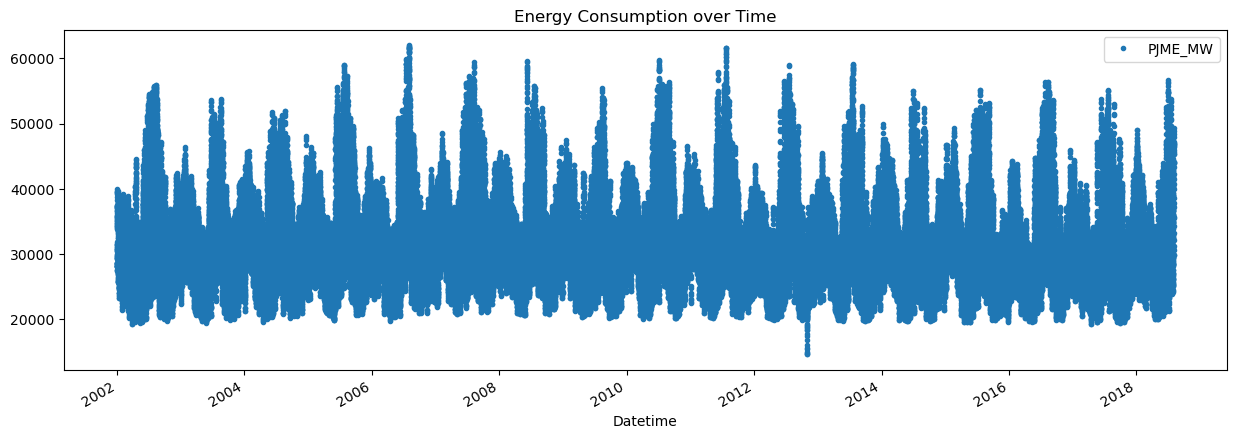

In [10]:
df.plot(style='.',figsize=(15,5),color=colour_palette[0],title='Energy Consumption over Time')

# 2. Create Training & Test Split

In [11]:
train_split = df.loc[df.index <'01-01-2015;']
test_split = df.loc[df.index >='01-01-2015;' ]

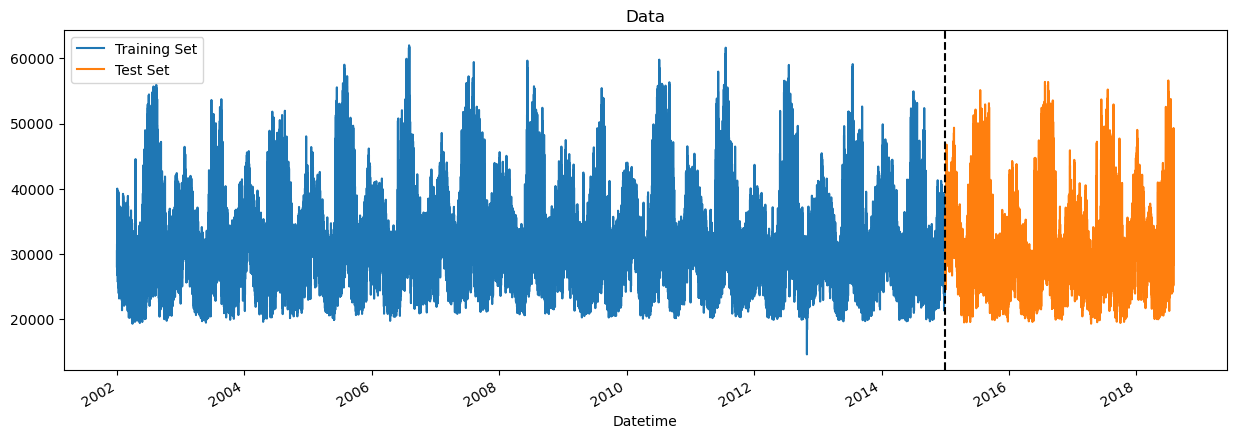

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
train_split.plot(ax=ax, label = 'Training Set', title='Data')
test_split.plot(ax=ax,label='Test Set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

<Axes: xlabel='Datetime'>

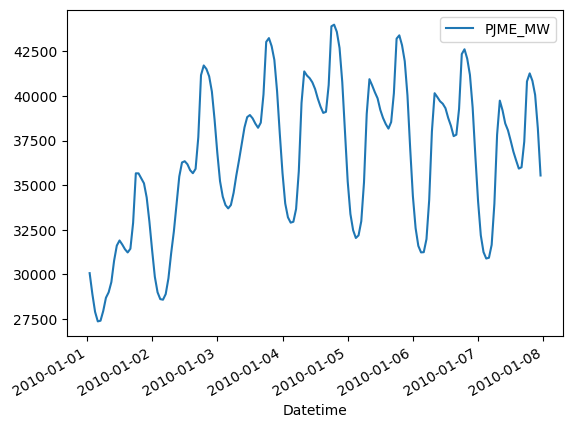

In [13]:
df.loc[(df.index>'01-01-2010') & (df.index < '01-08-2010')].plot()

 # Creating Features

In [14]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [15]:
df = create_features(df)

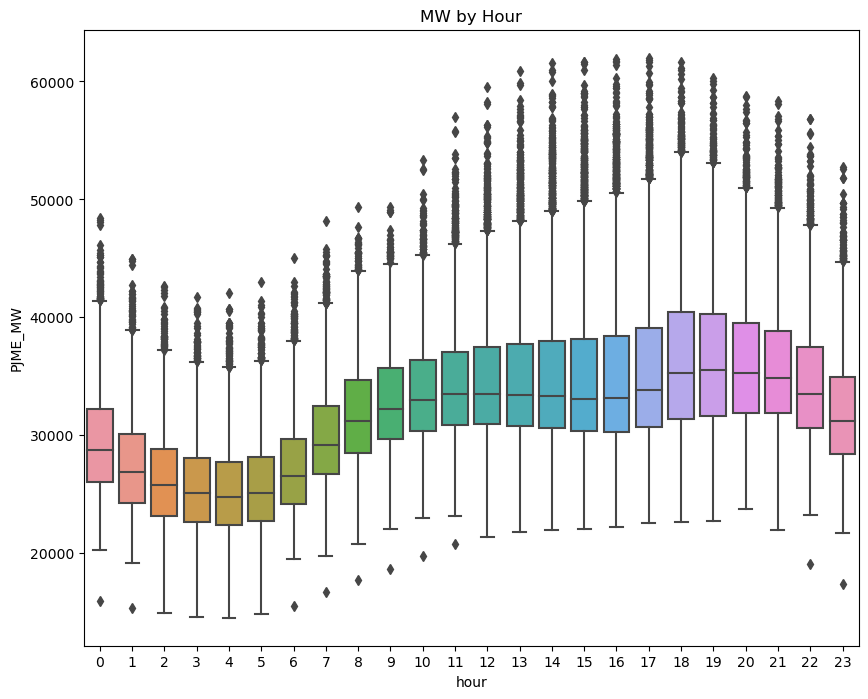

In [16]:
# Visualise Feature / Target Relationship
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='hour',y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

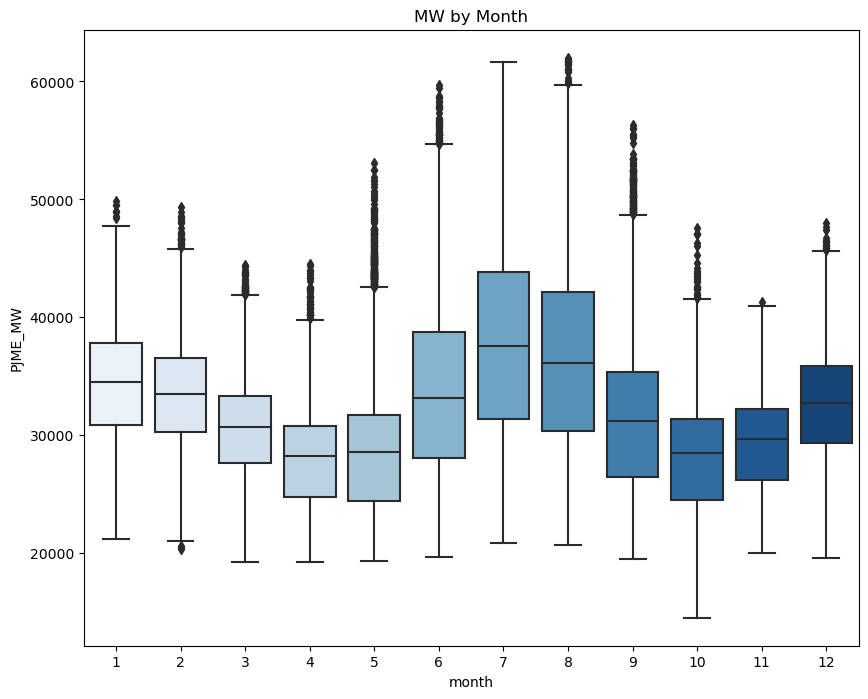

In [17]:
# Visualise Feature / Target Relationship 
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='PJME_MW',palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Creating the Model

In [18]:
train_split = create_features(train_split)
test_split = create_features(test_split)

In [19]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
target = 'PJME_MW'

In [20]:
X_train = train_split[features]
y_train = train_split[target]

X_test = test_split[features]
Y_test = test_split[target]

In [21]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, Y_test)],
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [22]:
feature_importance = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

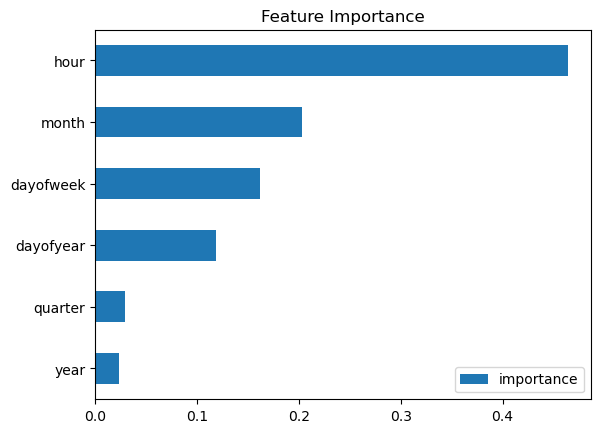

In [23]:
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')

# Forecast on Test

In [24]:
reg.predict(X_test)

array([32393.352, 29040.168, 27877.018, ..., 36229.527, 35141.754,
       32339.713], dtype=float32)

In [25]:
test_split['prediction'] = reg.predict(X_test)

In [26]:
df = df.merge(test_split[['prediction']], how='left', left_index=True, right_index=True)

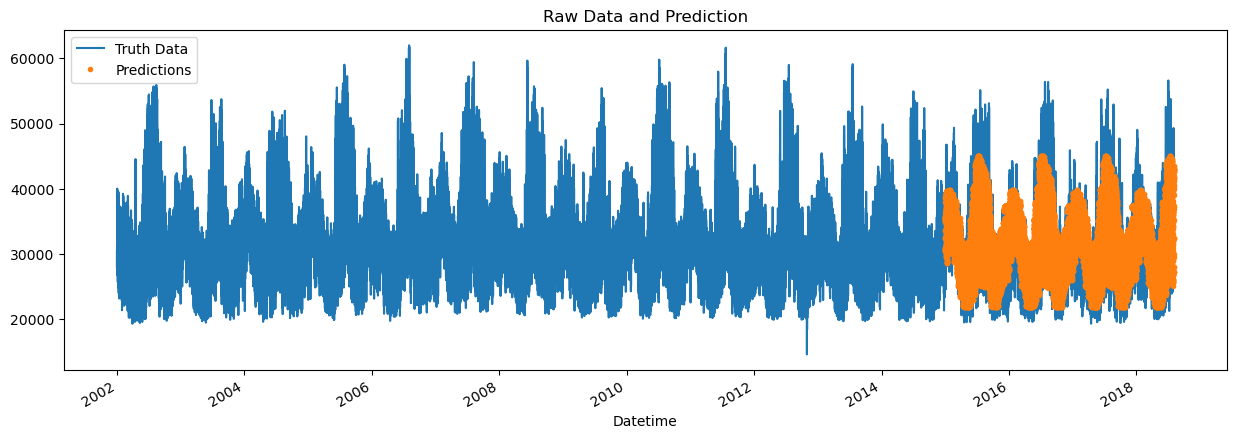

In [28]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.') 
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()
 

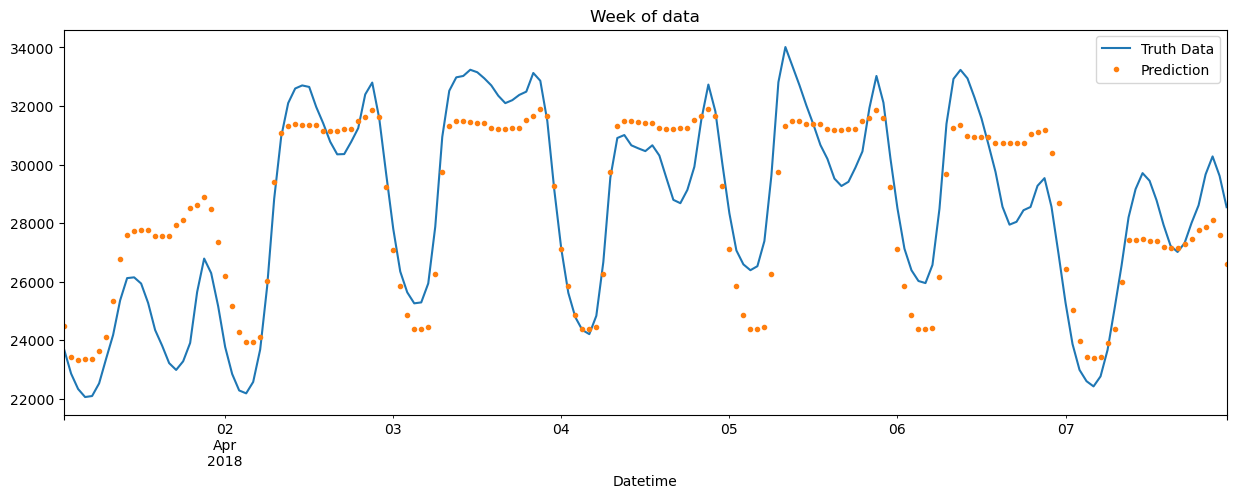

In [30]:
ax = df.loc[(df.index>'04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15,5),title='Week of data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Evaluation Metric (Mean Squared Error)

In [35]:
rmse = np.sqrt(mean_squared_error(test_split['PJME_MW'],test_split['prediction']))
print(f'RMSE on test set: {rmse:0.2f}')

RMSE on test set: 3741.03


## Calculate Actual Error

In [45]:
test_split['error'] = np.abs(test_split[target] - test_split['prediction'])
test_split['date'] = test_split.index.date
test_split.groupby('date')['error'].mean().sort_values(ascending=False).head(5)
#We can see that most of the days with the worst errors come from Mid August in 2016

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

# Advanced Modelling and Forecasting


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
colour_palette = sns.color_palette()
plt.style_use('fivethirtyright')

## Outline
- Forecasting horizon
- Time series cross-validation
- Outlier analysis
- Lag features (using past data to further improve the model's performance)
- Predicting the future using current data

In [14]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


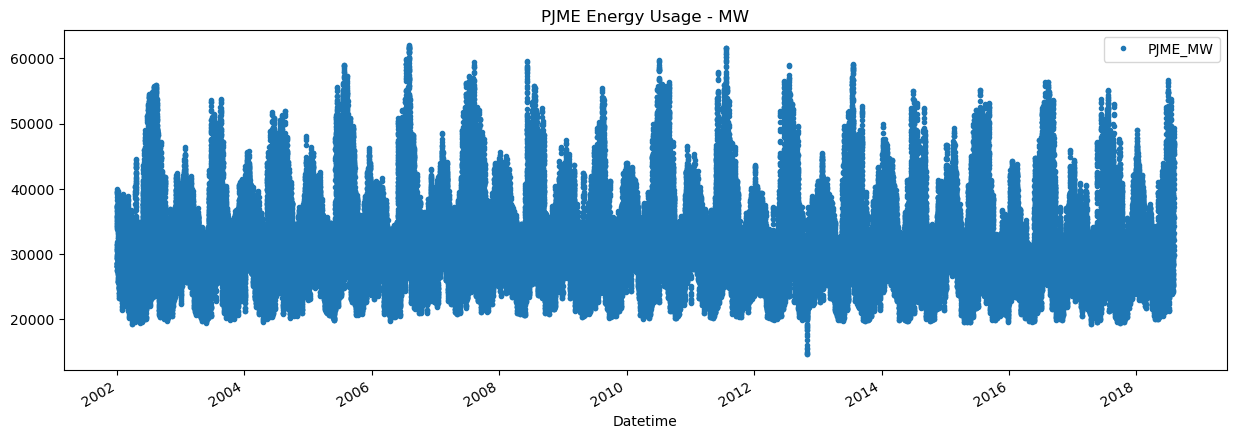

In [4]:
df.plot(style='.',figsize=(15,5),color=colour_palette[0],title='PJME Energy Usage - MW')
plt.show()

# 1. Finding Outliers

## Current Distribution

<Axes: ylabel='Frequency'>

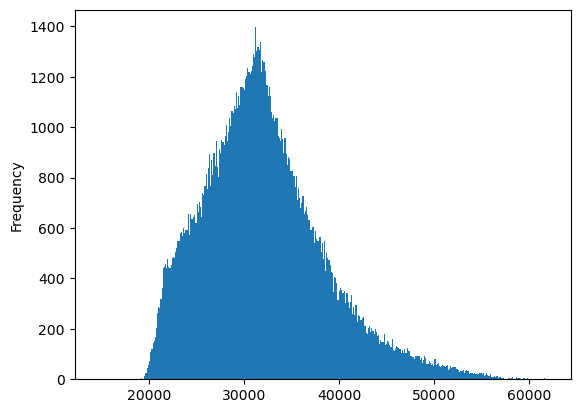

In [8]:
df['PJME_MW'].plot(kind='hist',bins=400)

<Axes: xlabel='Datetime'>

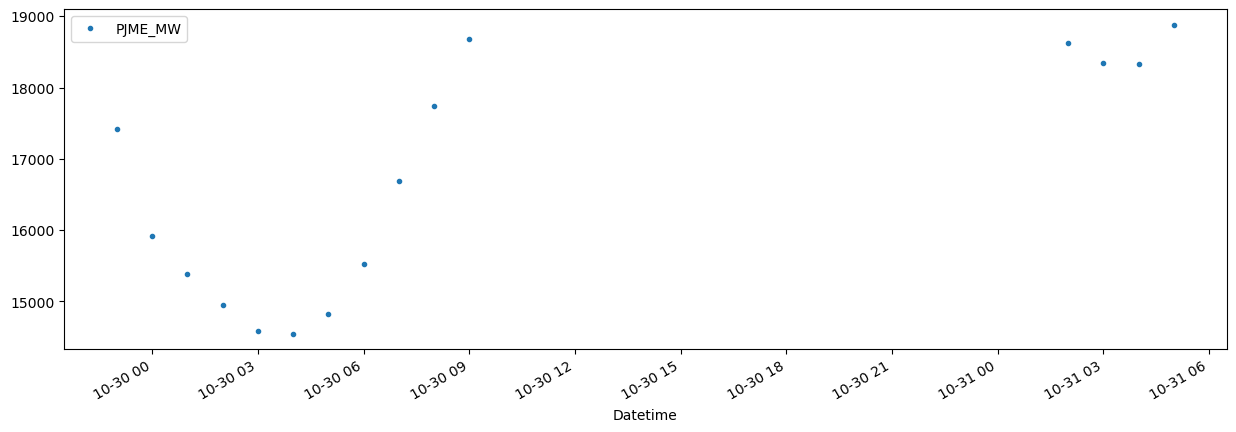

In [6]:
df.query('PJME_MW < 19000').plot(figsize=(15,5),style='.')

In [35]:
df = df.query('PJME_MW > 19_000').copy()

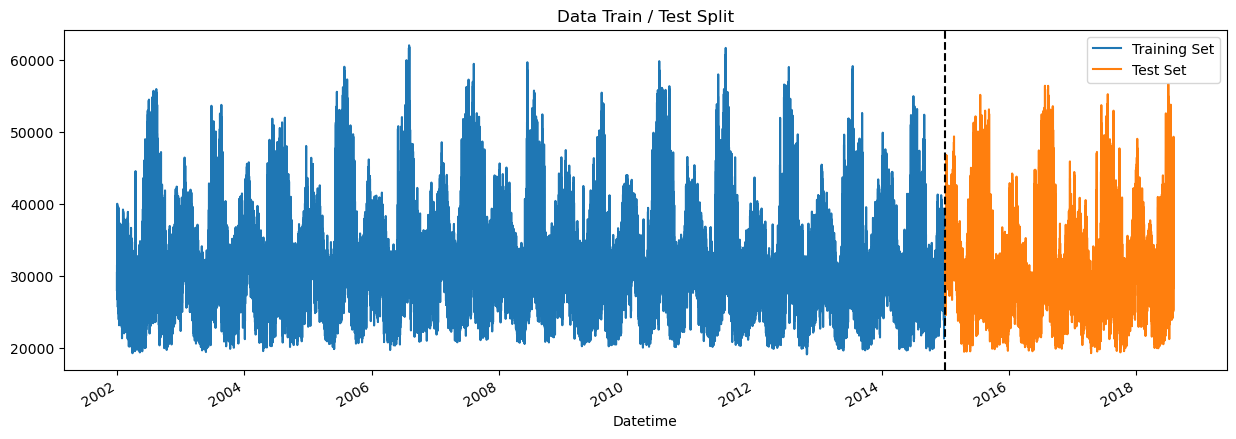

In [36]:
#Reviewing: Train / Test Split
train_split = df.loc[df.index < '01-01-2015']
test_split = df.loc[df.index >= '01-01-2015']

fig,ax = plt.subplots(figsize=(15,5))
train_split.plot(ax=ax, label='Training Set',title='Data Train / Test Split')
test_split.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 2. Time-series Cross Validation

In [37]:
from sklearn.model_selection import TimeSeriesSplit

time_series_split = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

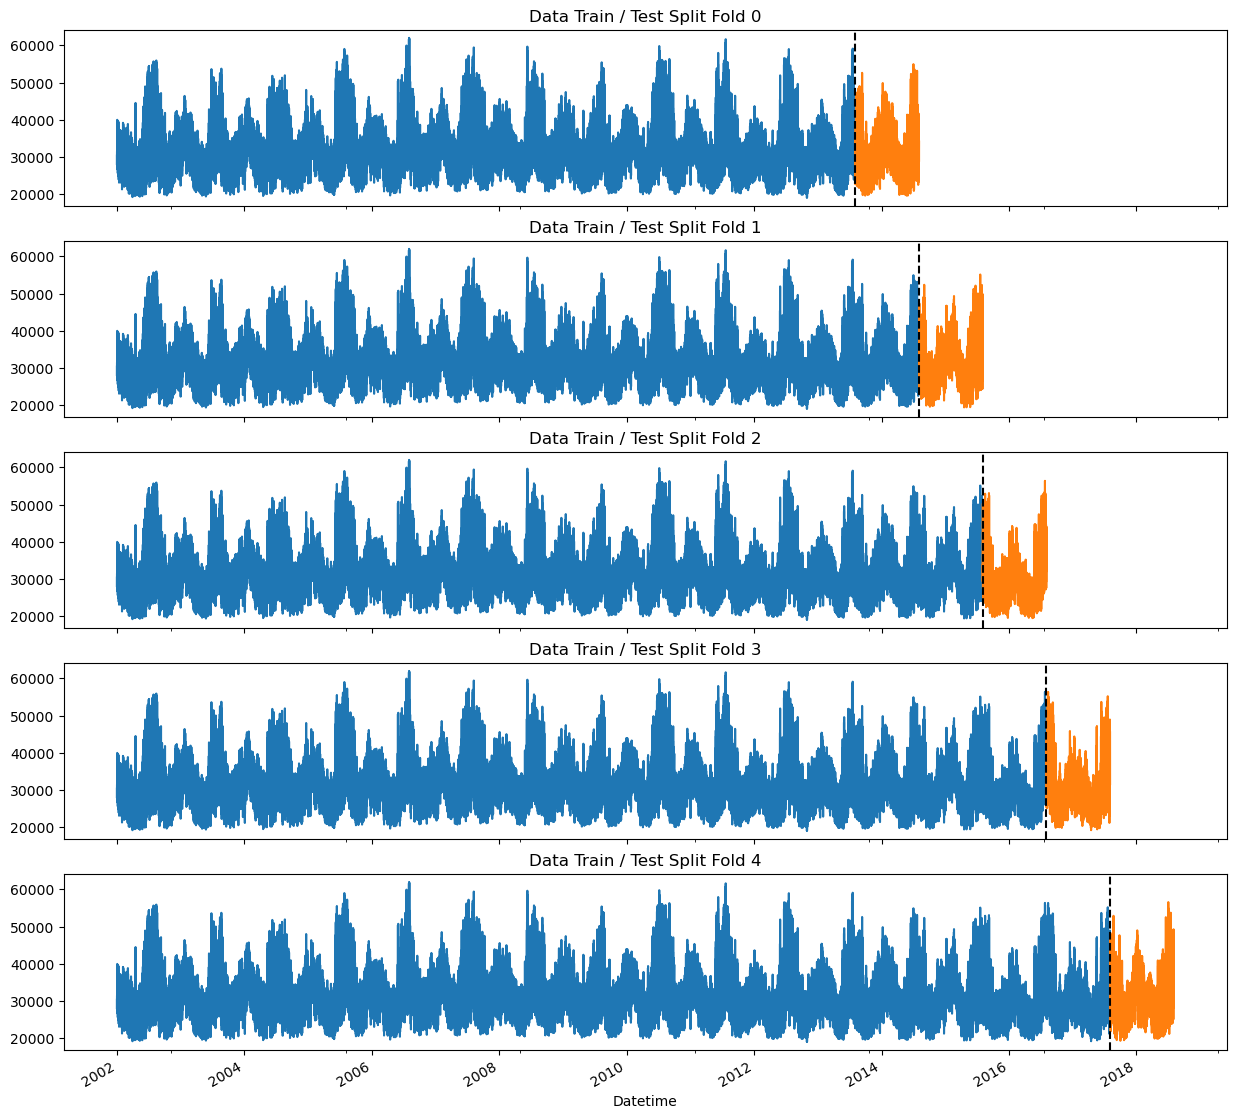

In [39]:
fig, axs = plt.subplots(5,1,figsize=(15,15),
                            sharex=True)
fold = 0
for train_idx, val_idx in time_series_split.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]
    train_split['PJME_MW'].plot(ax=axs[fold], label='Training Set', title=f'Data Train / Test Split Fold {fold}')
    test_split['PJME_MW'].plot(ax=axs[fold],label='Test Set')
    axs[fold].axvline(test_split.index.min(),color='black',ls='--')
    fold += 1

# 3.  Forecasting Horizon

A forecast horizon is simply how far into the future the forecast will be prepared

In [40]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df
df = create_features(df)

# 4. Lag Features

In [47]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    # used 364 as 364 is perfectly divisible by 7. This gives us the same day / date 
    # as the year before
    return df

In [48]:
df = add_lags(df)

In [55]:
time_series_split = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in time_series_split.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]
    
    train_split = create_features(train_split)
    test_split = create_features(test_split)
    
    features = ['dayofyear','hour', 'dayofweek', 'month', 'quarter', 'year','lag1', 'lag2', 'lag3']
    target = 'PJME_MW'
    
    X_train = train_split[features]
    y_train = train_split[target]
    
    X_test = test_split[features]
    y_test = test_split[target]
    
    reg = xgb.XGBRegressor(base_score=0.5,booster='gbtree',n_estimators=1000,early_stopping_rounds=50,objective='reg:linear',max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)


[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


C:\Users\s1151173\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


C:\Users\s1151173\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:01:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


C:\Users\s1151173\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:01:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.72805
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.21239
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.40541
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.25153
[411]	validation_0-rmse:3475.26636	validation_1-rmse:3503.58192
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


C:\Users\s1151173\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:01:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.30026	validation_1-rmse:12019.98579
[200]	validation_0-rmse:5738.32648	validation_1-rmse:5794.44193
[300]	validation_0-rmse:3915.76448	validation_1-rmse:4385.51180
[400]	validation_0-rmse:3499.03653	validation_1-rmse:4172.17589
[500]	validation_0-rmse:3382.83569	validation_1-rmse:4116.88298
[600]	validation_0-rmse:3324.23232	validation_1-rmse:4104.48851
[700]	validation_0-rmse:3281.46398	validation_1-rmse:4088.10832
[800]	validation_0-rmse:3249.57813	validation_1-rmse:4081.68309
[900]	validation_0-rmse:3223.05405	validation_1-rmse:4071.80961
[999]	validation_0-rmse:3198.63557	validation_1-rmse:4048.63496
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


C:\Users\s1151173\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.92077	validation_1-rmse:11962.25620
[200]	validation_0-rmse:5752.09311	validation_1-rmse:5610.63120
[300]	validation_0-rmse:3953.21146	validation_1-rmse:4149.60103
[400]	validation_0-rmse:3541.03825	validation_1-rmse:3998.83825
[440]	validation_0-rmse:3481.72497	validation_1-rmse:4001.67488


In [56]:
scores

[3760.8277187583353,
 3420.313091887879,
 3477.9504020604863,
 4048.634962892725,
 3994.9029963460744]

In [59]:
print(f'Average score was {np.mean(scores)}')

Average score was 3740.525834389101


# 4. Predicting the future
- Retrain model using all gathered data
- Run dates through prediction code + lag creation

## 4.1 Prep work (creating dataframes etc)

In [61]:
#Retrain model on all data
df = create_features(df)
 
features = ['dayofyear','hour', 'dayofweek', 'month', 'quarter', 'year','lag1', 'lag2', 'lag3']
target = 'PJME_MW'

X_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5,booster='gbtree',n_estimators=500,objective='reg:linear',max_depth=3,learning_rate=0.01)
reg.fit(X_all,y_all, eval_set=[(X_all, y_all)],
       verbose=100)


[0]	validation_0-rmse:32403.88991


C:\Users\s1151173\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:17:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.77634
[200]	validation_0-rmse:5753.18185
[300]	validation_0-rmse:3970.09750
[400]	validation_0-rmse:3569.04143
[499]	validation_0-rmse:3456.41787


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [62]:
#Create future dataframe
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [70]:
#From the output above, we can see that our dataset only has results going to 2018-08-03. We will now predict results 
# for this date to 2018-08-01 at 1h intervals
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [71]:
future_w_features = df_and_future.query('isFuture').copy()

In [72]:
future_w_features

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,8,3,2018,215,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,8,3,2018,215,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,8,3,2018,215,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,8,3,2018,215,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,8,3,2018,215,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,7,3,2019,212,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,7,3,2019,212,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,7,3,2019,212,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,7,3,2019,212,40666.0,34555.0,34641.0,True


## 4.2 Predicting future energy consumption

In [73]:
future_w_features['pred'] = reg.predict(future_w_features[features])

<Axes: title={'center': 'Future Energy Use Predictions'}>

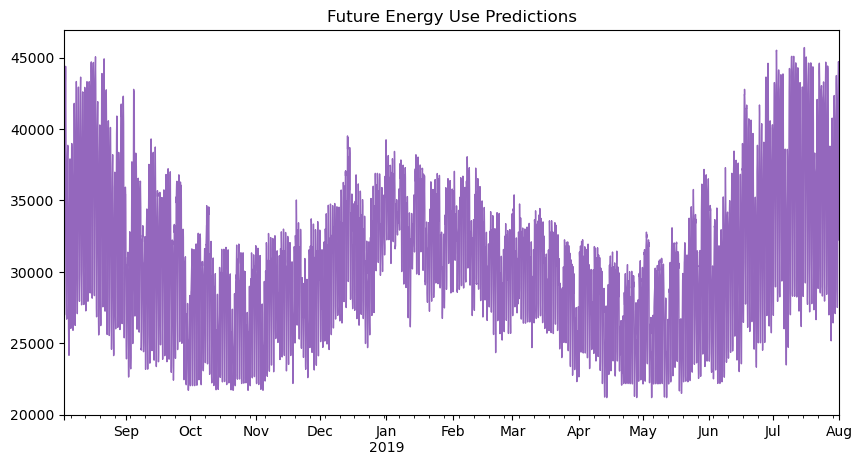

In [74]:
future_w_features['pred'].plot(figsize=(10,5),color=colour_palette[4],ms=1,lw=1,title='Future Energy Use Predictions')